By @Virus_Friendly

In [1]:
import base64
import json
import matplotlib
import pandas
import time

In [2]:
def find_frame(data):
    begin = -1
    
    if data[:2] != b'\x10\x02':
        for i in range(1, len(data)-7):
            if data[i:i+4] == b'\x10\x03\x10\x02':
                begin = i+2
                break
    else:
        begin = 0
    
    return(begin)

In [3]:
def parse_frame(data):
    padding = find_frame(data)
    
    if find_frame(data) == -1:
        display('Bad Frame')
        display(data)
        return None
        
    data = data[padding:]

    if data[5+data[3]:data[3]+7] != b'\x10\x03':
        if find_frame(data[5+data[3]:]) == -1:
            display('Frame Length Fail')
            return None
        
        # This data uses 0x1002 to symbolize start of frame and 0x1003 to symbolize the end of frame
        # To protect against 0x1003 being included in the datastream and misinterpreted as an end of frame
        # The device escapes 0x10 as 0x1010. Thus 0x1003 will become 0x101003.
        # This causes our length checks to fail, so we must detect them and de-escape the 0x1010 sequence
        
        frags = list()
        frag_start = 0
        
        for x in range(2, 5+data[3]+find_frame(data[5+data[3]:])):
            if data[x:x+2] == b'\x10\x10' and x >= frag_start:
                padding=padding+1
                frags.append(data[frag_start:x+1])
                frag_start = x+2
        
        if 0 < frag_start < len(data):
            frags.append(data[frag_start:])
            
        y=b''.join(frags)
        
        if (len(y) < 3) or (len(y) < y[3]+5) or (len(y) < y[3]+7) or (y[y[3]+5:y[3]+7] != b'\x10\x03'):
            display('bad frame not repaired')
            display(data[:5+data[3]+find_frame(data[5+data[3]:])])
            display(y[:data[3]+7])
            return None
        
        data=y

    n2kframe = dict()
    n2kframe['start'] = data[0:2]
    n2kframe['cmd'] = data[2]
    n2kframe['len'] = data[3]
    
    if n2kframe['cmd'] == 147:
        n2kframe['priority'] = data[4]
        n2kframe['pgn'] = int.from_bytes(data[5:8], 'little')
        n2kframe['dst'] = data[8]
        n2kframe['src'] = data[9]
        n2kframe['timestamp'] = int.from_bytes(data[10:14], 'little')
        n2kframe['datalen'] = data[14]

        if n2kframe['datalen'] > n2kframe['len']-11:
            display("Data Length Fail")
            return None

        pgndata = list()

        for byte in data[15:15+n2kframe['datalen']]:
            pgndata.append('{:02x}'.format(byte))

        n2kframe['data'] = ','.join(pgndata)
        n2kframe['crc'] = data[4+n2kframe['len']]
    else:
        unk_bytes = list()
        
        for byte in data[4:5+n2kframe['len']]:
            unk_bytes.append('{:02x}'.format(byte))
        
        n2kframe['data'] = ','.join(unk_bytes)
        
        for label in ['priority', 'pgn', 'dst', 'src', 'timestamp', 'datalen', 'crc']:
            n2kframe[label] = ''
    
    n2kframe['end'] = data[5+n2kframe['len']:5+n2kframe['len']+2]
    
    return n2kframe, n2kframe['len']+7+padding

In [4]:
def parse_frames(data):
    begin = 0
    n2kframes = list()
    
    begin = find_frame(data)
    
    frame_no = 0
    
    while(True):
        if begin < 0:
            print("Could not find next frame")
            break
        elif begin > len(data)-7:
            break
            
        parsed_data = parse_frame(data[begin:])
        
        if parsed_data == None:
            # print ("Bad frame at %s, finding next frame" % frame_no)
            begin=begin+7+find_frame(data[begin+7:])
            continue
            
        (frame, length) = parsed_data
        n2kframes.append(frame)
        begin=begin+length
        
        frame_no = frame_no+1
    
    return n2kframes

In [5]:
def parse_timestamp(timestamp):
    epoch = timestamp/1000.0
    millsec = timestamp%1000
    epoch_str = time.strftime('%Y-%m-%d-%H:%M:%S', time.gmtime(epoch))
    return "%s.%d" % (epoch_str, millsec)

In [6]:
def parse_log(logfile):
    lines = None
    capture = b''
    maxtime = 0

    with open(logfile) as n2klog:
        lines = n2klog.read().splitlines()

    for line in lines:
        log=json.loads(line)

        if int(log["milliunixtimestamp"]) >= maxtime:
            if 0 == maxtime:
                display(f"First timestamp: {int(log['milliunixtimestamp'])}")
                
            maxtime=int(log["milliunixtimestamp"])
        else:
            print("!!!!OUT OF SEQUENCE LOG!!!!!")
            print(maxtime, int(log["milliunixtimestamp"]))

        data = base64.b64decode(log['data'])
        capture = capture+data
        
    display(f"Last timestamp: {maxtime}")

    return pandas.DataFrame(parse_frames(capture))

In [7]:
n2k_logs = list()
print("first log")
n2k_logs.append(parse_log('NMEA2000PacketCapture.log'))

first log


'First timestamp: 1596659569526'

'Last timestamp: 1596659850800'

'Frame Length Fail'

In [8]:
for n2k_log in n2k_logs:
    display(n2k_log[n2k_log.src == 16])

,start,cmd,len,priority,pgn,dst,src,timestamp,datalen,data,crc,end
15,b'\x10\x02',147,19,3,61184,0,16,317823,8,"00,7d,7d,00,00,00,06,00",244,b'\x10\x03'
41,b'\x10\x02',147,19,3,61184,0,16,317873,8,"00,7d,7d,00,00,00,06,00",194,b'\x10\x03'
55,b'\x10\x02',147,19,3,61184,0,16,317923,8,"00,7d,7d,00,00,00,06,00",144,b'\x10\x03'
68,b'\x10\x02',147,19,3,61184,0,16,317973,8,"00,7d,7d,00,00,00,06,00",93,b'\x10\x03'
86,b'\x10\x02',147,19,6,65271,255,16,318022,8,"ff,ff,ff,ff,6c,01,ff,ff",189,b'\x10\x03'
...,...,...,...,...,...,...,...,...,...,...,...,...
91281,b'\x10\x02',147,19,6,65271,255,16,598963,8,"ff,ff,ff,ff,6c,01,ff,ff",2,b'\x10\x03'
91282,b'\x10\x02',147,19,6,65280,255,16,598964,8,"50,6c,01,ff,ff,d4,ff,ff",209,b'\x10\x03'
91284,b'\x10\x02',147,19,3,61184,0,16,598965,8,"01,7d,7d,00,00,00,06,00",110,b'\x10\x03'
91304,b'\x10\x02',147,19,3,61184,0,16,599015,8,"01,7d,7d,00,00,00,06,00",60,b'\x10\x03'


Canbus Layout

```
 0                   1                   2                   3
 0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9 0 1
+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
|S| ID                  |R|E| ID (continued)                    |
+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+

SAE J1939 Overlay
+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
|S| Pri |R|D|PDU Format |R|E|PF | PDU Specific  | Source Address|
+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+

NMEA2000 PGN1 Overlay (PDU Format < 0xF0
+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
|S| Pri |R| PGN1        |R|E|P1 | Dest Address  | Source Address|
+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+

NMEA2000 PGN2 Overlay
+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
|S| Pri |R| PGN2        |R|E| PGN2 (Continued)  | Source Address|
+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
```

We can reconstitue the Canbus ID using te NMEA2000 Priority, PGN, Source Address, and optional Destination Address

In [9]:
target_pgns = [61184,65280,65281]

In [10]:
can_maps = list()
can_ids = list()

for pgn in target_pgns:
    pgn_data = n2k_log[n2k_log.pgn == pgn]
    
    for x in range(len(pgn_data)):
        can_id = pgn
        pri, dst, src = pgn_data[['priority','dst', 'src']].iloc[x]
        
        if (pgn&0xFFFF) < 0xF000:
            can_id = can_id + dst
        
        can_id = can_id + (pri << 18)
        can_id = src + (can_id << 8)
        
        if can_id not in can_ids:
            can_ids.append(can_id)
            can_map=dict()
            can_map["can_id"] = can_id
            can_map["can_id (hex)"] = hex(can_id)
            can_map["pgn"] = pgn
            can_map["priority"] = pri
            can_map["dst"] = dst
            can_map["src"] = src
            can_maps.append(can_map)

canbus_map = pandas.DataFrame(can_maps)
display(canbus_map.sort_values(by=['src']))

,can_id,can_id (hex),pgn,priority,dst,src
4,216989712,0xcef0010,61184,3,0,16
10,419364880,0x18ff0010,65280,6,255,16
2,216989728,0xcef0020,61184,3,0,32
6,419364896,0x18ff0020,65280,6,255,32
12,419365152,0x18ff0120,65281,6,255,32
1,216989744,0xcef0030,61184,3,0,48
7,419364912,0x18ff0030,65280,6,255,48
11,419365168,0x18ff0130,65281,6,255,48
8,419364913,0x18ff0031,65280,6,255,49
13,419365169,0x18ff0131,65281,6,255,49


One clue that these are not NMEA2000 or SAE J1939 messages is that several of them are destined for address 0, which is the Actisense probe.

In [11]:
can_rows = list()

for n2k_log in n2k_logs:
    for pgn in target_pgns:
        pgn_data = n2k_log[n2k_log.pgn == pgn]
        #rows = pgn_data.iterrows()

        for x in range(len(pgn_data)):
            #row = next(rows)
            can_id = pgn
            pri, dst, src, timestamp, data = pgn_data[['priority','dst', 'src', 'timestamp', 'data']].iloc[x]

            if (pgn&0xFFFF) < 0xF000:
                can_id = can_id + dst

            can_id = can_id + (pri << 18)
            can_id = src + (can_id << 8)

            can_row=dict()
            can_row["can_id"] = can_id
            can_row["timestamp"] = timestamp
            can_row["data"] = data
            can_rows.append(can_row)

canbus_log = pandas.DataFrame(can_rows)
display(canbus_log)

,can_id,timestamp,data
0,216989761,317786,"0f,00,00,ff,ff,ff,ff,00"
1,216989744,317790,"04,00,7d,00,00,01,06,00"
2,216989728,317799,"00,3f,00,ff,30,ff,05,00"
3,216989746,317807,"00,00,7d,00,0f,01,05,00"
4,216989712,317823,"00,7d,7d,00,00,00,06,00"
...,...,...,...
60525,419365152,599028,"00,b4,01,00,87,00,85,00"
60526,419365169,599029,"1f,01,21,00,ff,07,00,00"
60527,419365168,599059,"4d,0e,20,00,ff,07,00,00"
60528,419365169,599078,"1f,01,21,00,ff,07,00,00"


In [12]:
data_widths=list()

for can_id in canbus_log.sort_values(by=['can_id']).can_id.unique():
    devicelog = canbus_log[canbus_log.can_id == can_id]
    data_width=dict()
    data_width["can_id"] = can_id
    data_width["num_unique_values"] = len(devicelog.data.unique())
    data_width["total_values"] = len(devicelog)
    data_width["start_time"] = devicelog.timestamp.iloc[0]
    data_width["end_time"] = devicelog.timestamp.iloc[-1]
    data_width["timelength"] = (devicelog.timestamp.iloc[-1]) - (devicelog.timestamp.iloc[0])
    data_widths.append(data_width)

display(pandas.DataFrame(data_widths))

,can_id,num_unique_values,total_values,start_time,end_time,timelength
0,216989712,23,5607,317823,599065,281242
1,216989728,154,5607,317799,599076,281277
2,216989744,138,5608,317790,599058,281268
3,216989746,30,5608,317807,599077,281270
4,216989760,3,5602,317835,599086,281251
5,216989761,1,5603,317786,599087,281301
6,419364880,8,1121,318023,598964,280941
7,419364896,111,5607,317799,599077,281278
8,419364912,7,1122,317821,598989,281168
9,419364913,7,1122,317839,599008,281169


The data field in canbus messages can contain multiple data groups known as signals. By analyzing the entropy of the data field, we can make assumptions of how the signals are grouped.

Typically, the value printed is the number of different values (in hex) seen in that byte.

Data bytes that have only a single value can still provide useful information.

* If the signle value is 0, this is represented as 'ZZ' to allow for quickly identifying leading zeros.
* If the single value is 0xff, this is represented as 'XX' since this oftens signals invalid or unsused fields.
* Other wise, this byte is effectively a constant and represented as 'CC'

In [13]:
for can_id in canbus_log.sort_values(by=['can_id']).can_id.unique():
    canid_log = canbus_log[canbus_log.can_id == can_id]
    signals = list()
    
    for x in range(8):
        signals.append(list())
    
    for datas in canid_log.data:
        data = datas.split(',')
        
        if len(data) > 8:
            print("data is unexpectedly long")
        
        for x in range(8):
            if data[x] not in signals[x]:
                signals[x].append(data[x])
        
    sgn_fmt = list()

    for signal in signals:
        if len(signal) == 1:
            if signal[0] == 'ff':
                sgn_fmt.append('XX')
            elif signal[0] == '00':
                sgn_fmt.append('ZZ')
            else:
                sgn_fmt.append('CC')
        else:
            sgn_fmt.append(hex(len(signal))[2:].zfill(2))
        
    display(str(can_id) + '    ' + ' '.join(sgn_fmt))

'216989712    05 03 03 ZZ ZZ ZZ 0b ZZ'

'216989728    03 CC 83 XX 02 XX 03 ZZ'

'216989744    03 71 03 ZZ ZZ CC 03 ZZ'

'216989746    04 19 02 ZZ 02 CC 03 ZZ'

'216989760    03 ZZ ZZ XX XX XX XX ZZ'

'216989761    CC ZZ ZZ XX XX XX XX ZZ'

'419364880    CC 08 CC XX XX CC XX XX'

'419364896    CC 0a CC 54 ZZ XX XX CC'

'419364912    CC 02 02 02 ZZ XX CC 02'

'419364913    CC 02 02 02 ZZ XX CC 02'

'419364928    CC ZZ 02 ZZ CC XX XX XX'

'419365152    52 CC 8a 03 6f 04 8f 04'

'419365168    91 08 02 ZZ 9b 08 75 71'

'419365169    28 05 02 ZZ 29 05 18 19'

 0 1 2 3 4 5 6 7
+-+-+-+-+-+-+-+-+
|      0|0 0|  0| 216989712
+-+-+-+-+-+-+-+-+
|c c| |x|c|x|c 0| 216989728
+-+-+-+-+-+-+-+-+
|0 0|c 0|c c|c 0| 216989744
+-+-+-+-+-+-+-+-+
|c| |c 0 0|c|c 0| 216989746
+-+-+-+-+-+-+-+-+
|c 0 0|x x x x|0| 216989760
+-+-+-+-+-+-+-+-+
|c 0 0|x x x x|0| 216989761
+-+-+-+-+-+-+-+-+

In [14]:
# All activity occurs between these timestamps

#START_TIME = 23121358
#END_TIME = 23192867

START_TIME = 480000
END_TIME = 560000

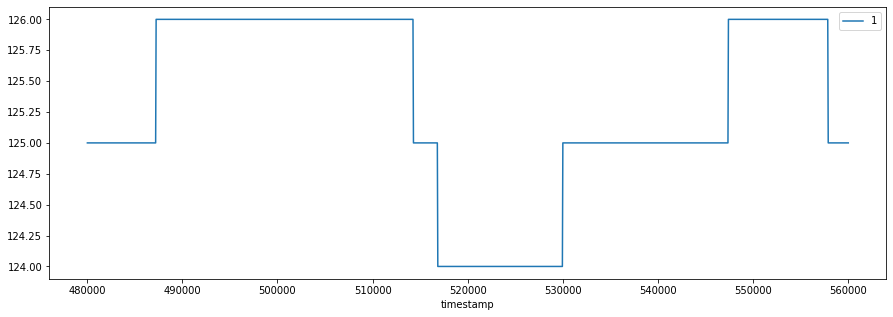

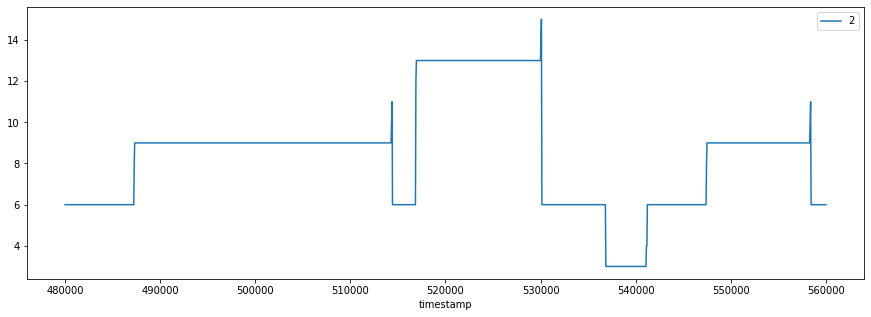

In [15]:
#  0 1 2 3 4 5 6 7
# +-+-+-+-+-+-+-+-+
# |      0|0 0|  0| 216989712
# +-+-+-+-+-+-+-+-+

canid_log = canbus_log[canbus_log.can_id == 216989712]
signal_log = list()

for x in range(len(canid_log)):
    signals = (canid_log.data.iloc[x]).split(',')
    
    signal = dict()
    signal["timestamp"] = canid_log.timestamp.iloc[x]
    
    if (signal["timestamp"] < START_TIME) or (signal["timestamp"] > END_TIME):
        continue
        
    #signal["1"] = int(''.join([signals[3],signals[2],signals[1],signals[0]]), 16)
    signal["1"] = int(''.join([signals[1]]), 16)
    signal["2"] = int(''.join([signals[7],signals[6]]), 16)

    
    signal_log.append(signal)

for signal in ['1','2']:
    pandas.DataFrame(signal_log).plot(x='timestamp', y=signal,figsize=(15,5))

In [16]:
canid_log = canbus_log[canbus_log.can_id == 216989712]

for x in range(len(canid_log)):
    signals = (canid_log.data.iloc[x]).split(',')
    
    y = int(''.join([signals[1]]), 16)
    
    if y < 125:
        #display(y)
        canid, ts, data = canid_log.iloc[x]
        display(data)
        break

'00,7c,7d,00,00,00,06,00'

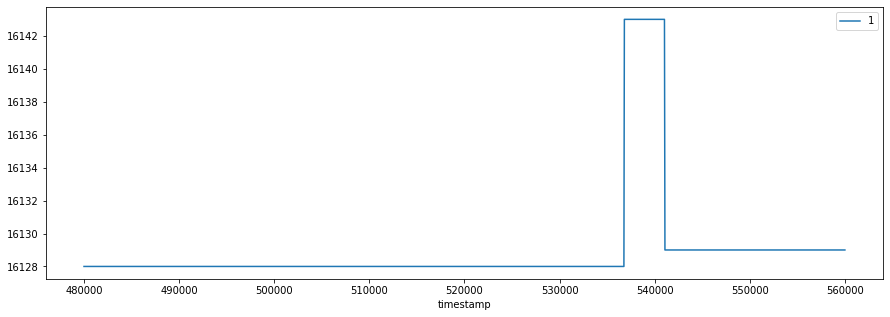

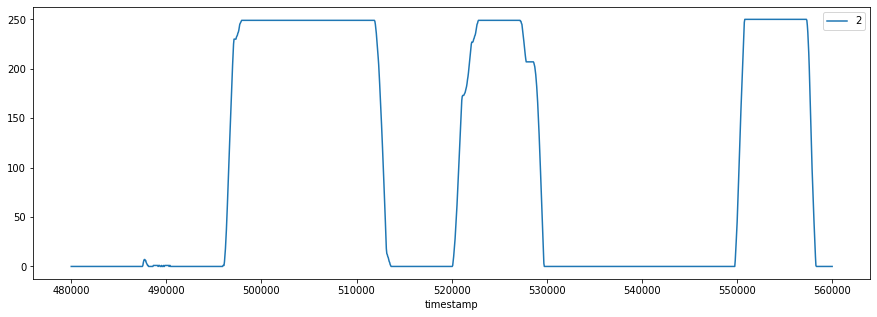

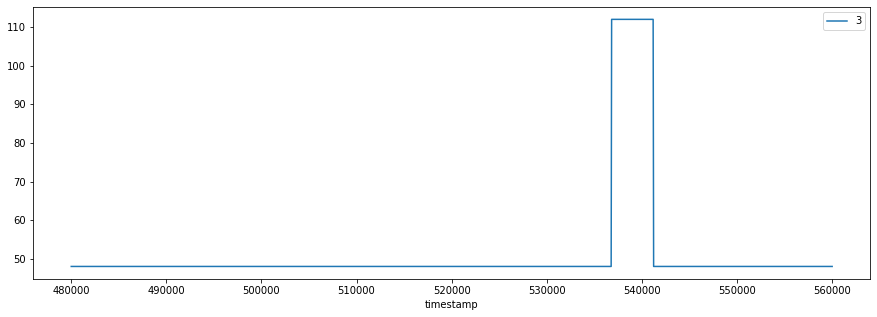

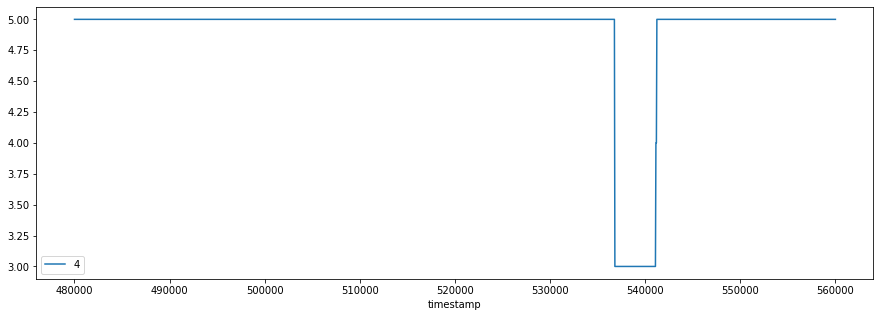

In [17]:
#  0 1 2 3 4 5 6 7
# +-+-+-+-+-+-+-+-+
# |   | |x| |x|   | 216989728
# +-+-+-+-+-+-+-+-+

canid_log = canbus_log[canbus_log.can_id == 216989728]
signal_log = list()

for x in range(len(canid_log)):
    signals = (canid_log.data.iloc[x]).split(',')
    
    signal = dict()
    signal["timestamp"] = canid_log.timestamp.iloc[x]
    
    if (signal["timestamp"] < START_TIME) or (signal["timestamp"] > END_TIME):
        continue
        
    signal["1"] = int(''.join([signals[1],signals[0]]), 16)
    signal["2"] = int(signals[2], 16)
    signal["3"] = int(signals[4], 16)
    signal["4"] = int(''.join([signals[7],signals[6]]), 16)
    
    signal_log.append(signal)

for signal in ['1','2','3','4']:
    pandas.DataFrame(signal_log).plot(x='timestamp', y=signal,figsize=(15,5))

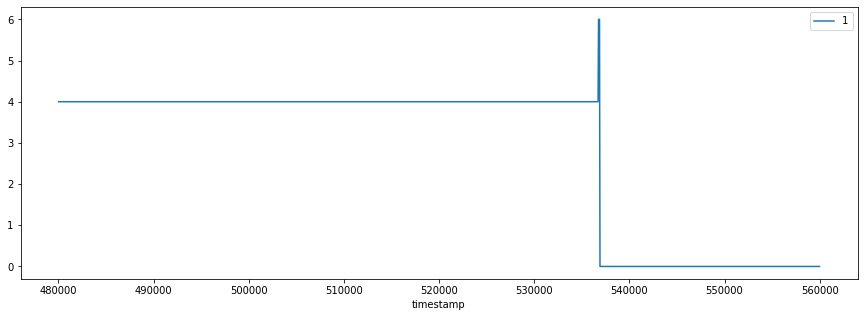

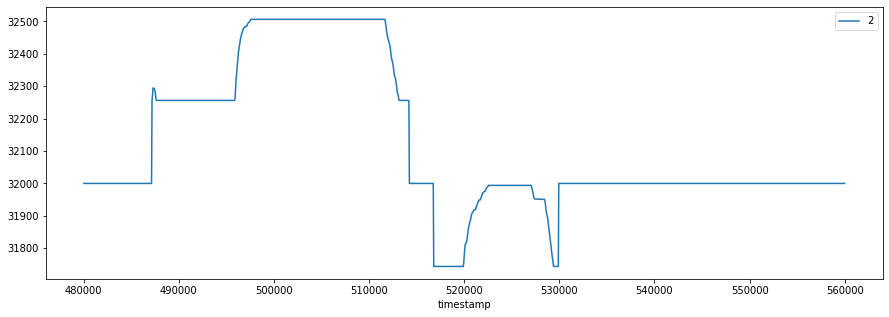

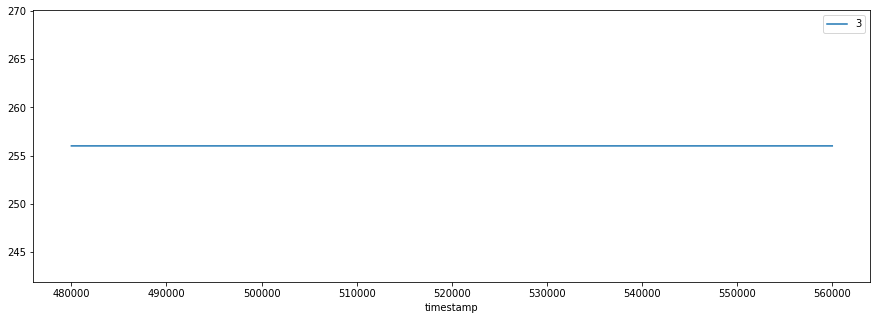

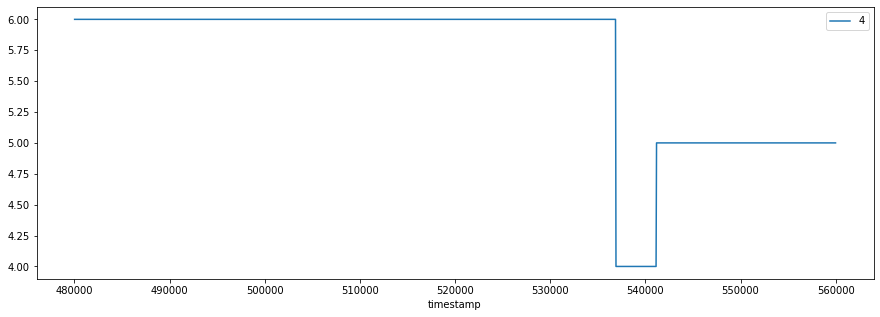

In [18]:
#  0 1 2 3 4 5 6 7
# +-+-+-+-+-+-+-+-+
# | |       |c|   | 216989744
# +-+-+-+-+-+-+-+-+

canid_log = canbus_log[canbus_log.can_id == 216989744]
signal_log = list()

for x in range(len(canid_log)):
    signals = (canid_log.data.iloc[x]).split(',')
    
    signal = dict()
    signal["timestamp"] = canid_log.timestamp.iloc[x]
    
    if (signal["timestamp"] < START_TIME) or (signal["timestamp"] > END_TIME):
        continue
    
    signal["1"] = int(signals[0], 16)
    signal["2"] = int(''.join([signals[3],signals[2],signals[1]]), 16)
    signal["3"] = int(''.join([signals[5],signals[4]]), 16)
    signal["4"] = int(''.join([signals[7],signals[6]]), 16)
    
    signal_log.append(signal)

for signal in ['1','2','3','4']:
    pandas.DataFrame(signal_log).plot(x='timestamp', y=signal,figsize=(15,5))

In [19]:
canid_log = canbus_log[canbus_log.can_id == 216989744]

for x in range(len(canid_log)):
    signals = (canid_log.data.iloc[x]).split(',')
    
    y = int(''.join([signals[3],signals[2],signals[1]]), 16) 
    
    if y > 32500:
        canid, ts, data = canid_log.iloc[x]
        display(canid, data)
        break

216989744

'04,f7,7e,00,00,01,06,00'

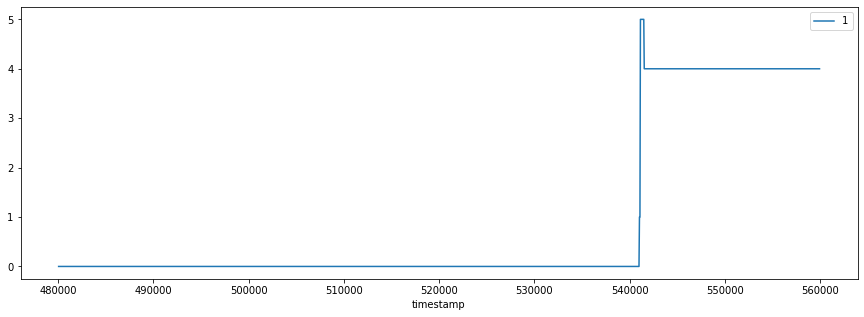

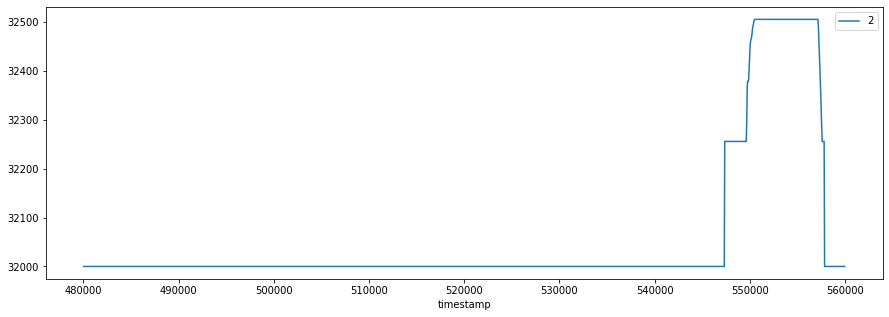

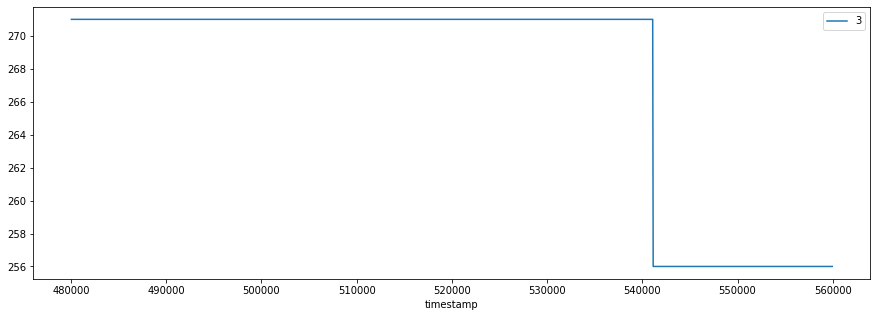

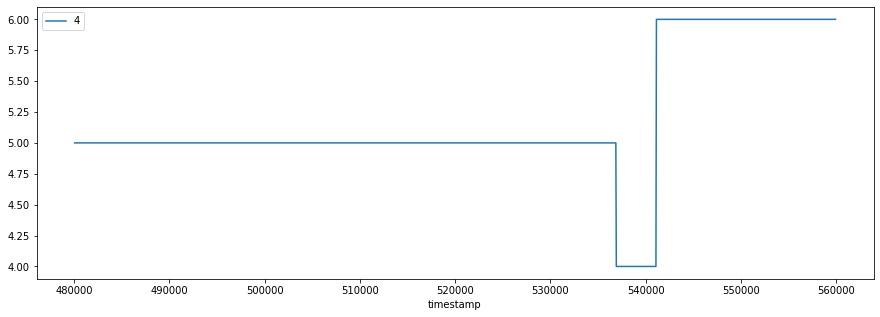

In [20]:
#  0 1 2 3 4 5 6 7
# +-+-+-+-+-+-+-+-+
# | |     |   |   | 216989746
# +-+-+-+-+-+-+-+-+

canid_log = canbus_log[canbus_log.can_id == 216989746]
signal_log = list()

for x in range(len(canid_log)):
    signals = (canid_log.data.iloc[x]).split(',')
    
    signal = dict()
    signal["timestamp"] = canid_log.timestamp.iloc[x]
    
    if (signal["timestamp"] < START_TIME) or (signal["timestamp"] > END_TIME):
        continue

    signal["1"] = int(signals[0], 16)
    signal["2"] = int(''.join([signals[3],signals[2],signals[1]]), 16)
    signal["3"] = int(''.join([signals[5],signals[4]]), 16)
    signal["4"] = int(''.join([signals[7],signals[6]]), 16)
    
    signal_log.append(signal)

for signal in ['1','2','3','4']:
    pandas.DataFrame(signal_log).plot(x='timestamp', y=signal,figsize=(15,5))

In [21]:
canid_log = canbus_log[canbus_log.can_id == 216989746]

for x in range(len(canid_log)):
    signals = (canid_log.data.iloc[x]).split(',')
    
    y = int(''.join([signals[3],signals[2],signals[1]]), 16) 
    
    if y == 32000:
        #display(y)
        canid, ts, data = canid_log.iloc[x]
        display(canid, data)
        break

216989746

'00,00,7d,00,0f,01,05,00'

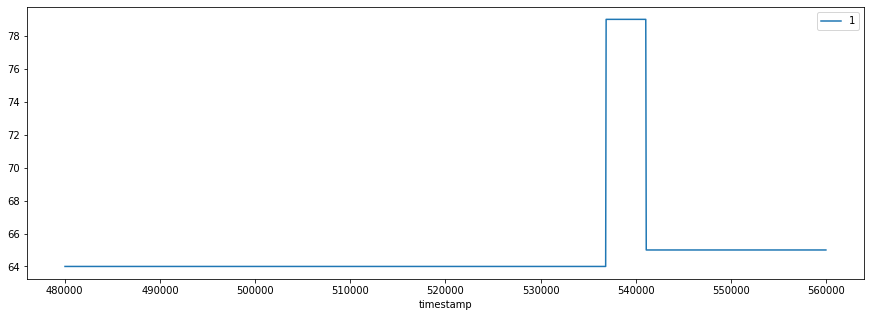

In [22]:
#  0 1 2 3 4 5 6 7
# +-+-+-+-+-+-+-+-+
# |     |x x x x|c| 216989760
# +-+-+-+-+-+-+-+-+

canid_log = canbus_log[canbus_log.can_id == 216989760]
signal_log = list()

for x in range(len(canid_log)):
    signals = (canid_log.data.iloc[x]).split(',')
    
    signal = dict()
    signal["timestamp"] = canid_log.timestamp.iloc[x]
    
    if (signal["timestamp"] < START_TIME) or (signal["timestamp"] > END_TIME):
        continue
        
    signal["1"] = int(''.join([signals[2],signals[1],signals[0]]), 16)
    
    signal_log.append(signal)

for signal in ['1']:
    pandas.DataFrame(signal_log).plot(x='timestamp', y=signal,figsize=(15,5))

In [23]:
#  0 1 2 3 4 5 6 7
# +-+-+-+-+-+-+-+-+
# |c c c|x x x x|c| 216989761
# +-+-+-+-+-+-+-+-+

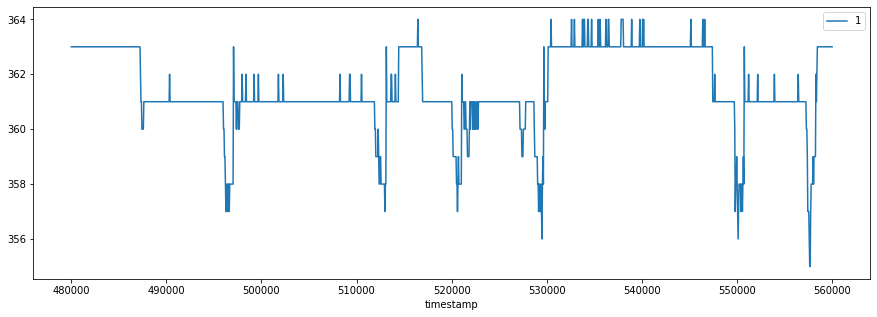

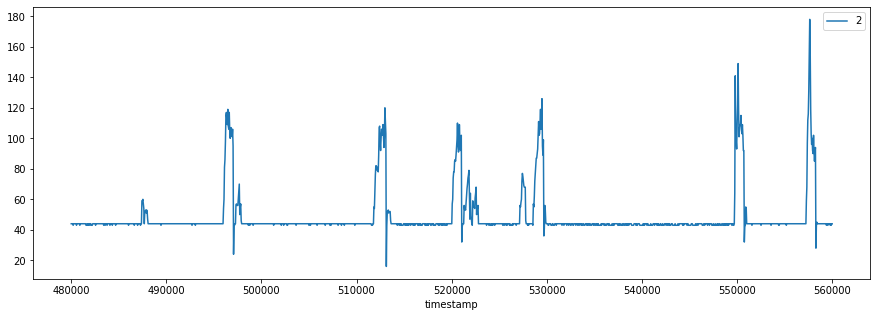

In [24]:
#  0 1 2 3 4 5 6 7
# +-+-+-+-+-+-+-+-+
# |c|   |   |x x|c| 419364896
# +-+-+-+-+-+-+-+-+

canid_log = canbus_log[canbus_log.can_id == 419364896]
signal_log = list()

for x in range(len(canid_log)):
    signals = (canid_log.data.iloc[x]).split(',')
    
    signal = dict()
    signal["timestamp"] = canid_log.timestamp.iloc[x]
    
    if (signal["timestamp"] < START_TIME) or (signal["timestamp"] > END_TIME):
        continue
        
    signal["1"] = int(''.join([signals[2],signals[1]]), 16)
    signal["2"] = int(''.join([signals[4],signals[3]]), 16)
    
    signal_log.append(signal)

for signal in ['1','2']:
    pandas.DataFrame(signal_log).plot(x='timestamp', y=signal,figsize=(15,5))

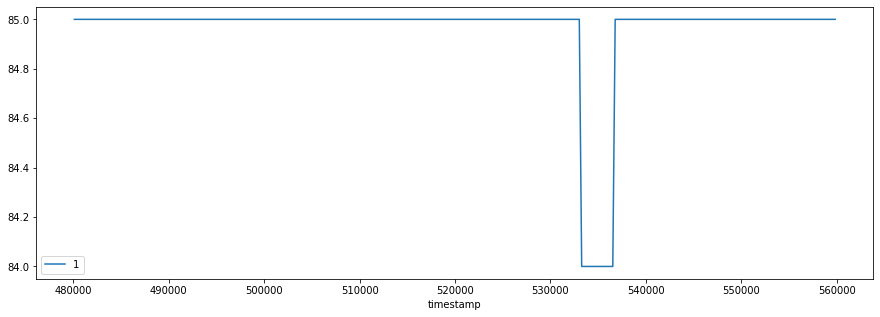

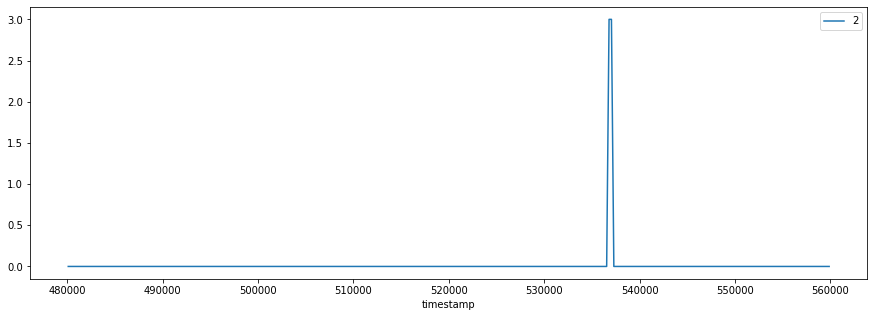

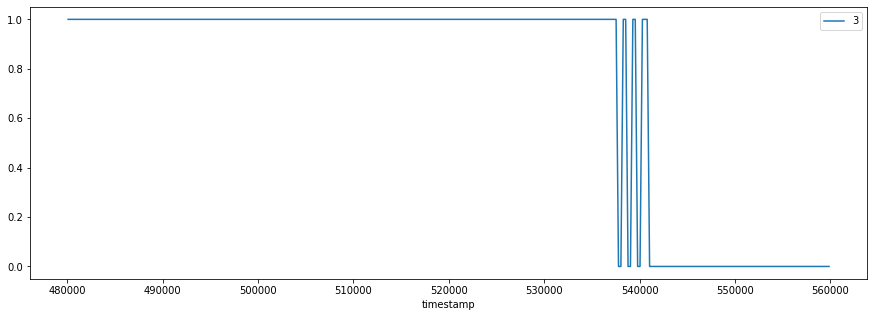

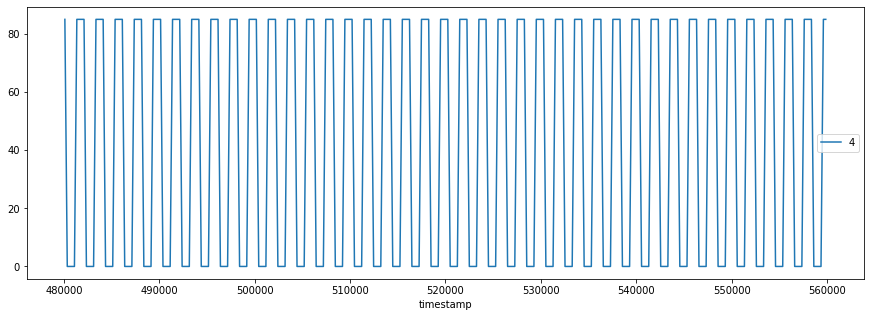

In [25]:
#  0 1 2 3 4 5 6 7
# +-+-+-+-+-+-+-+-+
# |c| | |   |x|c| | 419364912
# +-+-+-+-+-+-+-+-+

canid_log = canbus_log[canbus_log.can_id == 419364912]
signal_log = list()

for x in range(len(canid_log)):
    signals = (canid_log.data.iloc[x]).split(',')
    
    signal = dict()
    signal["timestamp"] = canid_log.timestamp.iloc[x]
    
    if (signal["timestamp"] < START_TIME) or (signal["timestamp"] > END_TIME):
        continue
    
    signal["1"] = int(signals[1], 16)
    signal["2"] = int(signals[2], 16)
    signal["3"] = int(''.join([signals[4],signals[3]]), 16)
    signal["4"] = int(signals[7], 16)
    
    signal_log.append(signal)

for signal in ['1','2','3','4']:
    pandas.DataFrame(signal_log).plot(x='timestamp', y=signal,figsize=(15,5))

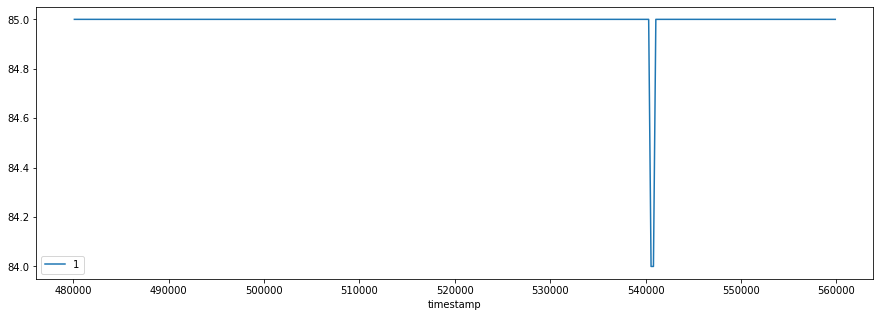

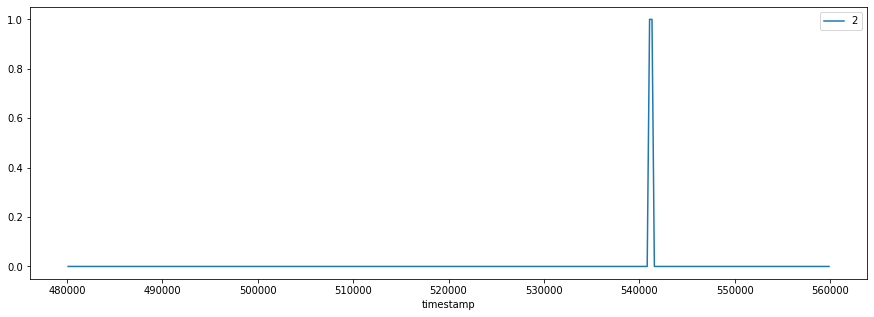

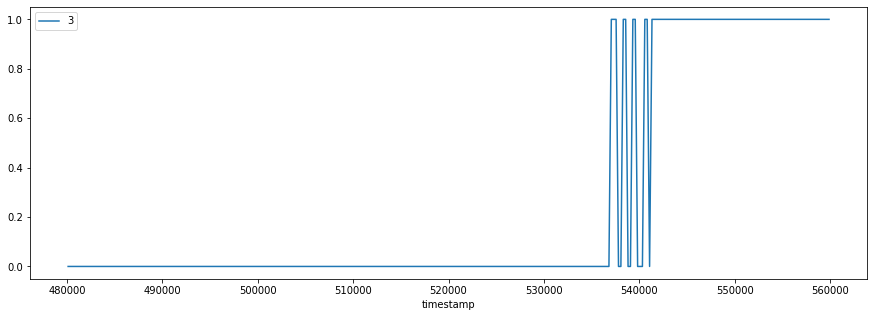

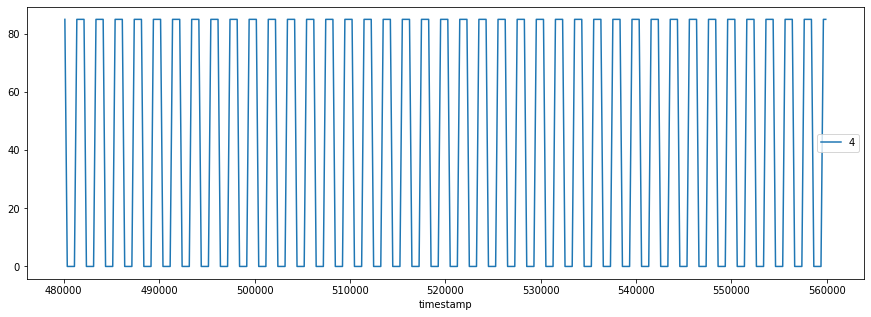

In [26]:
#  0 1 2 3 4 5 6 7
# +-+-+-+-+-+-+-+-+
# |c| | |   |x|c| | 419364913
# +-+-+-+-+-+-+-+-+

canid_log = canbus_log[canbus_log.can_id == 419364913]
signal_log = list()

for x in range(len(canid_log)):
    signals = (canid_log.data.iloc[x]).split(',')
    
    signal = dict()
    signal["timestamp"] = canid_log.timestamp.iloc[x]
    
    if (signal["timestamp"] < START_TIME) or (signal["timestamp"] > END_TIME):
        continue
    
    signal["1"] = int(signals[1], 16)
    signal["2"] = int(signals[2], 16)
    signal["3"] = int(''.join([signals[4],signals[3]]), 16)
    signal["4"] = int(signals[7], 16)
    
    signal_log.append(signal)

for signal in ['1','2','3','4']:
    pandas.DataFrame(signal_log).plot(x='timestamp', y=signal,figsize=(15,5))

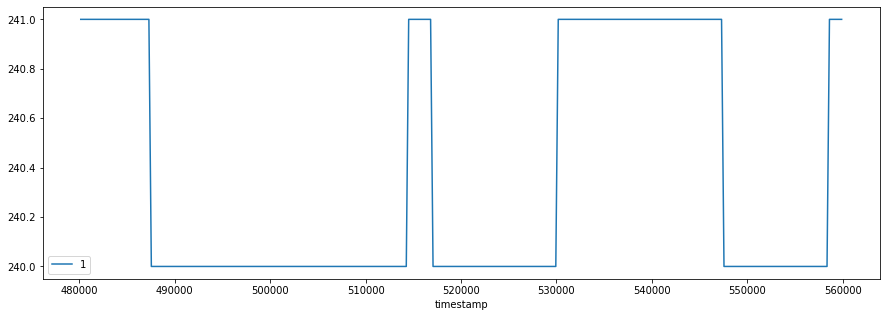

In [27]:
#  0 1 2 3 4 5 6 7
# +-+-+-+-+-+-+-+-+
# |c c|   |c|x x x| 419364928
# +-+-+-+-+-+-+-+-+

canid_log = canbus_log[canbus_log.can_id == 419364928]
signal_log = list()

for x in range(len(canid_log)):
    signals = (canid_log.data.iloc[x]).split(',')
    
    signal = dict()
    signal["timestamp"] = canid_log.timestamp.iloc[x]
    
    if (signal["timestamp"] < START_TIME) or (signal["timestamp"] > END_TIME):
        continue
    
    signal["1"] = int(''.join([signals[3],signals[2]]), 16)
    
    signal_log.append(signal)

for signal in ['1']:
    pandas.DataFrame(signal_log).plot(x='timestamp', y=signal,figsize=(15,5))

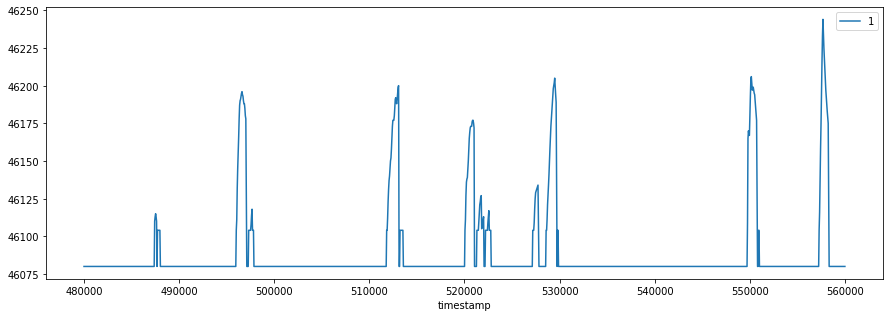

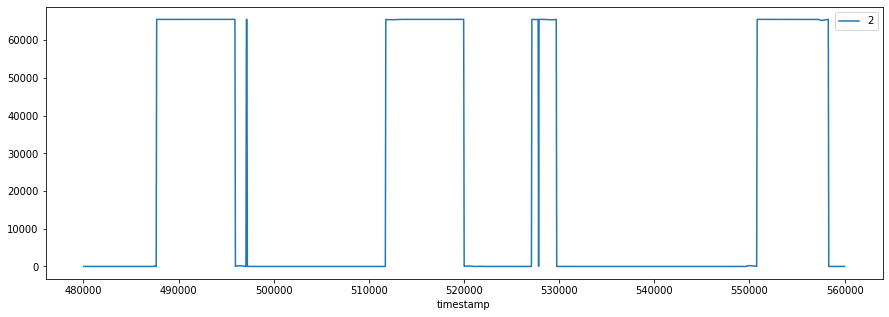

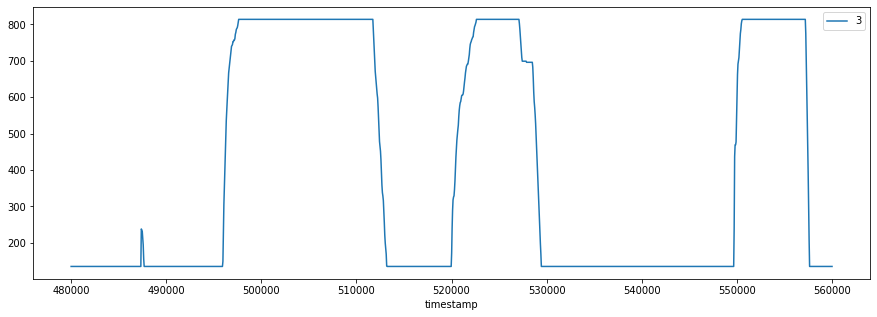

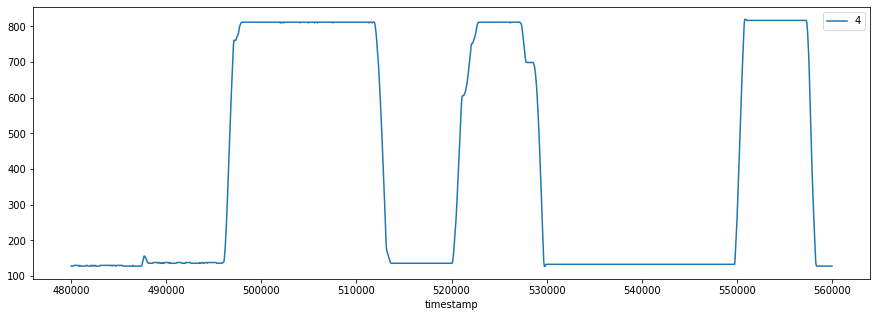

In [28]:
#  0 1 2 3 4 5 6 7
# +-+-+-+-+-+-+-+-+
# |   |   |   |   | 419365152
# +-+-+-+-+-+-+-+-+

canid_log = canbus_log[canbus_log.can_id == 419365152]
signal_log = list()

for x in range(len(canid_log)):
    signals = (canid_log.data.iloc[x]).split(',')
    
    signal = dict()
    signal["timestamp"] = canid_log.timestamp.iloc[x]
    
    if (signal["timestamp"] < START_TIME) or (signal["timestamp"] > END_TIME):
        continue
    
    signal["1"] = int(''.join([signals[1],signals[0]]), 16)
    signal["2"] = int(''.join([signals[3],signals[2]]), 16)
    signal["3"] = int(''.join([signals[5],signals[4]]), 16)
    signal["4"] = int(''.join([signals[7],signals[6]]), 16)
    
    signal_log.append(signal)

for signal in ['1','2','3','4']:
    pandas.DataFrame(signal_log).plot(x='timestamp', y=signal,figsize=(15,5))

In [29]:
canid_log = canbus_log[canbus_log.can_id == 419365152]

for x in range(len(canid_log)):
    signals = (canid_log.data.iloc[x]).split(',')
    
    y = int(''.join([signals[7],signals[6]]), 16) 
    
    if y < 130:
        #display(y)
        canid, ts, data = canid_log.iloc[x]
        display(data)
        break

'00,b4,04,00,87,00,80,00'

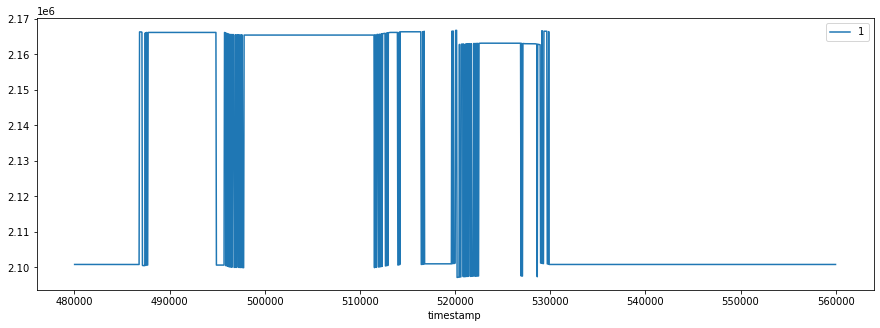

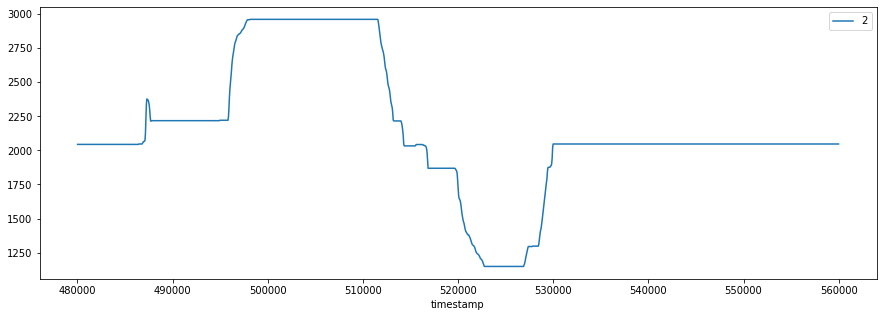

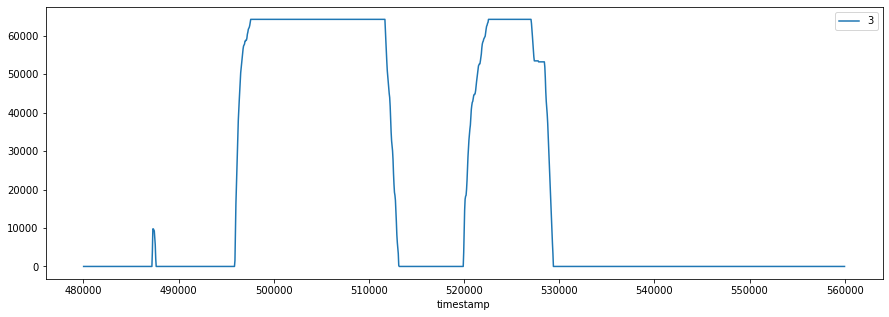

In [30]:
#  0 1 2 3 4 5 6 7
# +-+-+-+-+-+-+-+-+
# |       |   |   | 419365168
# +-+-+-+-+-+-+-+-+

canid_log = canbus_log[canbus_log.can_id == 419365168]
signal_log = list()

for x in range(len(canid_log)):
    signals = (canid_log.data.iloc[x]).split(',')
    
    signal = dict()
    signal["timestamp"] = canid_log.timestamp.iloc[x]
    
    if (signal["timestamp"] < START_TIME) or (signal["timestamp"] > END_TIME):
        continue
    
    signal["1"] = int(''.join([signals[3],signals[2],signals[1],signals[0]]), 16)
    signal["2"] = int(''.join([signals[5],signals[4]]), 16)
    signal["3"] = int(''.join([signals[7],signals[6]]), 16)
    
    signal_log.append(signal)

for signal in ['1','2','3']:
    pandas.DataFrame(signal_log).plot(x='timestamp', y=signal,figsize=(15,5))

In [31]:
canid_log = canbus_log[canbus_log.can_id == 419365168]

for x in range(len(canid_log)):
    signals = (canid_log.data.iloc[x]).split(',')
    
    y = int(''.join([signals[7],signals[6]]), 16) 
    
    if y == 0:
        #display(y)
        canid, ts, data = canid_log.iloc[x]
        display(data)
        break

'50,0e,20,00,fc,07,00,00'

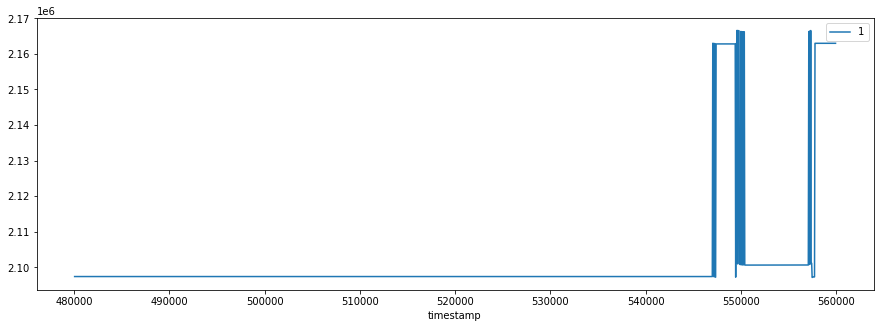

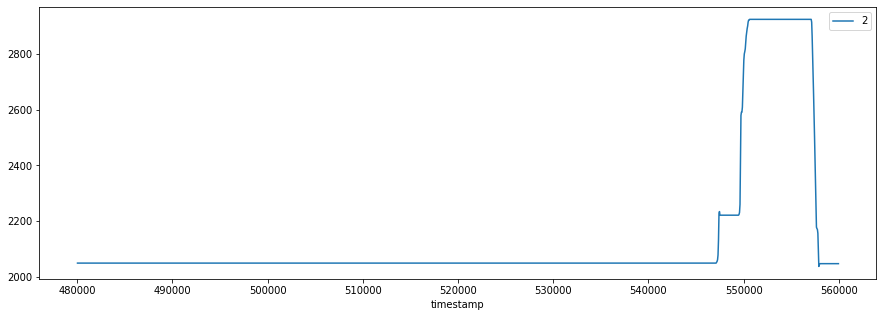

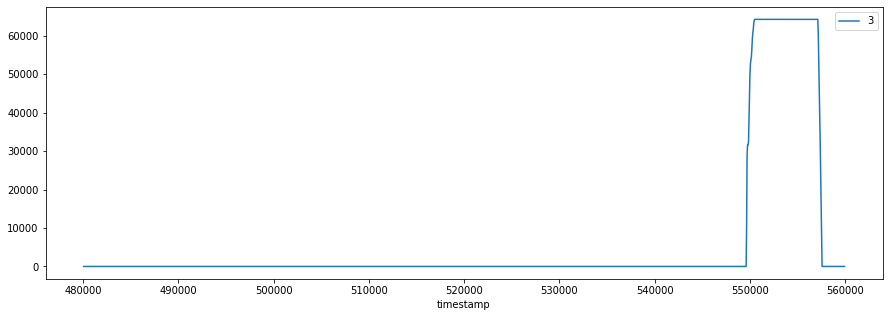

In [32]:
#  0 1 2 3 4 5 6 7
# +-+-+-+-+-+-+-+-+
# |       |   |   | 419365169
# +-+-+-+-+-+-+-+-+

canid_log = canbus_log[canbus_log.can_id == 419365169]
signal_log = list()

for x in range(len(canid_log)):
    signals = (canid_log.data.iloc[x]).split(',')
    
    signal = dict()
    signal["timestamp"] = canid_log.timestamp.iloc[x]
    
    if (signal["timestamp"] < START_TIME) or (signal["timestamp"] > END_TIME):
        continue
    
    signal["1"] = int(''.join([signals[3],signals[2],signals[1],signals[0]]), 16)
    signal["2"] = int(''.join([signals[5],signals[4]]), 16)
    signal["3"] = int(''.join([signals[7],signals[6]]), 16)
    
    signal_log.append(signal)

for signal in ['1','2','3']:
    pandas.DataFrame(signal_log).plot(x='timestamp', y=signal,figsize=(15,5))

Based on the data and timeline I've been able to create a model where each "Control Station" sends its throttle and enable signals to the "Control Unit" which determines which "Control Station" is enabled and sends its throttle information for the shift unit and actuators.

* 216989712 Shift Control
* 216989728 "Control Unit" enable & throttle
* 216989744 First "Control Station" enable & throttle
* 216989746 Second "Control Station" enable & throttle
* 216989760 "Control Unit" enable
* 216989761 Unknown
* 419364896 "Control Unit" (Needs more research)
* 419364912 First "Control Station" enable
* 419364913 Second "Control Station" enable
* 419364928 "Control Unit" Unknown
* 419365152 "Control Unit" throttle
* 419365168 First "Control Station" throttle
* 419365169 Second "Control Station" throttle